<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-и-предобработка-данных" data-toc-modified-id="Обзор-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор и предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Подготовка-данных-для-моделей" data-toc-modified-id="Подготовка-данных-для-моделей-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных для моделей</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование-моделей" data-toc-modified-id="Обучение-и-тестирование-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование-итоговой-модели" data-toc-modified-id="Тестирование-итоговой-модели-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тестирование итоговой модели</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно построить модель для прогнозирования количества заказов такси на следующий час.
План работы:
1. загрузить данные и выполнить их ресемплирование по одному часу;
2. проанализировать данные;
3. обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных;
4. проверить данные на тестовой выборке и сделать выводы.

Описание данных: данные лежат в файле taxi.csv. Количество заказов находится в столбце 'num_orders'.

## Обзор и предобработка данных

Импортируем необходимые инструменты:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Загрузим и проанализируем исходные данные:

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except: 
    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

Ресемплируем данные, проверим хронологичность их расположения, диапазон даты и времени:

In [3]:
df = df.resample('1H').sum()
df.index.is_monotonic, df.index.min(), df.index.max()

(True,
 Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

### Обзор данных

Проведем анализ данных:

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В данных отсутствуют пропуски, явные аномалии не наблюдаются.

Создадим функцию для отрисовки общего графика, а также графиков тренда, сезонности и шума:

In [6]:
def plot_decomposed(begin, end):
    # общий график
    df[begin : end].plot(figsize=(14,4))
    plt.title('Распределение значений по дате и времени')
    plt.tight_layout()
    # графики тренда, сезонности и шума
    plt.figure(figsize=(14, 14))
    plt.subplot(311)
    decomposed.trend[begin : end].plot(ax=plt.gca())
    plt.title('Тренд')
    plt.subplot(312)
    decomposed.seasonal[begin : end].plot(ax=plt.gca())
    plt.title('Сезонность')
    plt.subplot(313)
    decomposed.resid[begin : end].plot(ax=plt.gca())
    plt.title('Шум')
    plt.tight_layout()

Разобьем данные на тренд, сезонность и шум:

In [7]:
decomposed = seasonal_decompose(df['num_orders'])

Для лучшего выявления закономерностей исследуем данные за весь период, один месяц, одну неделю и одни сутки:

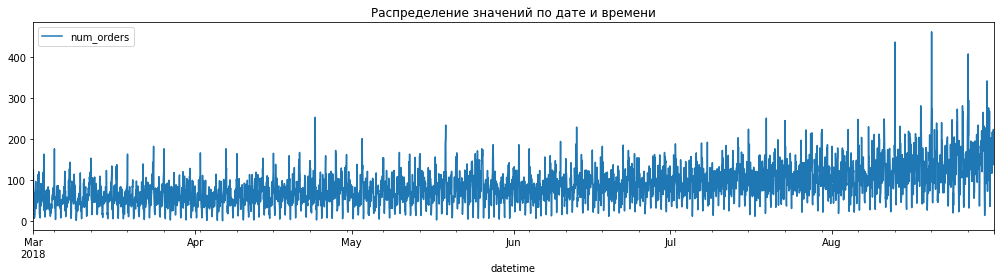

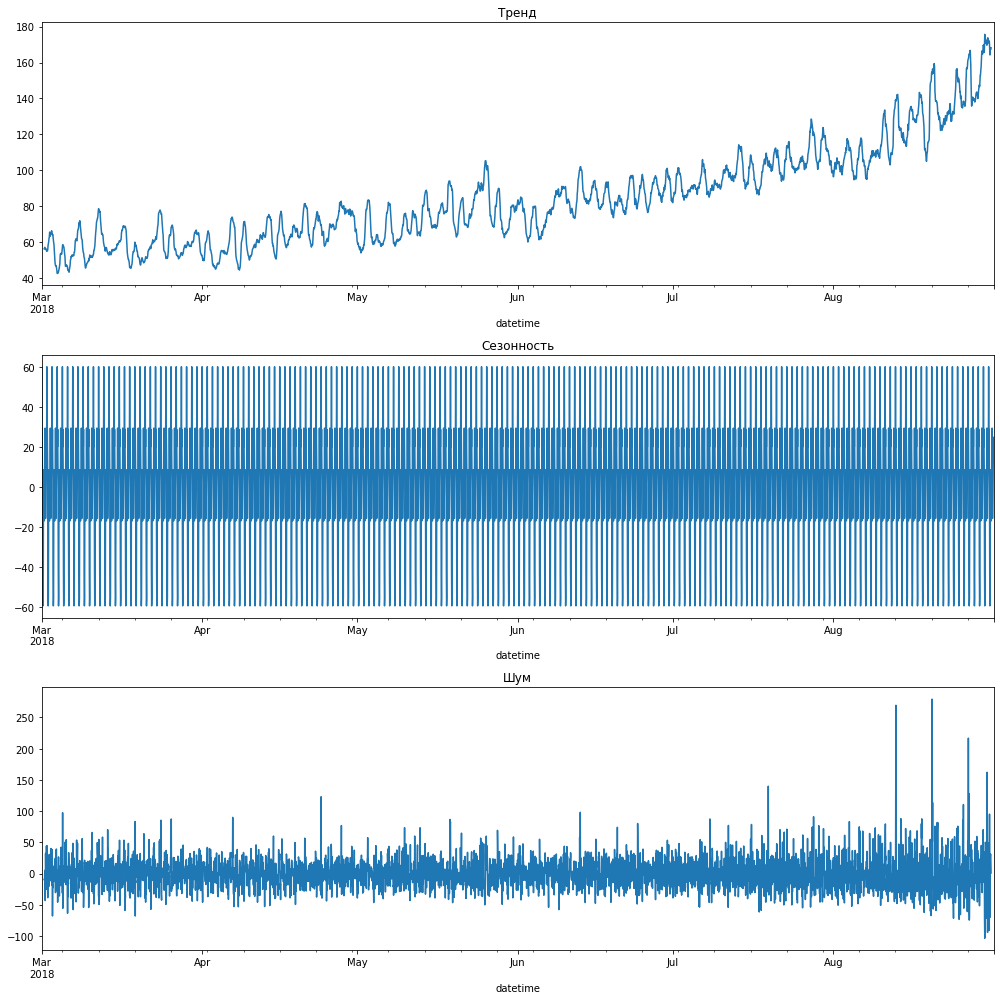

In [7]:
# весь период
plot_decomposed('2018', '2018')

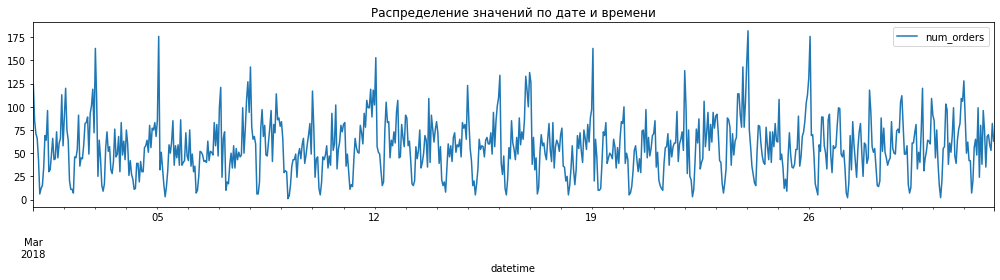

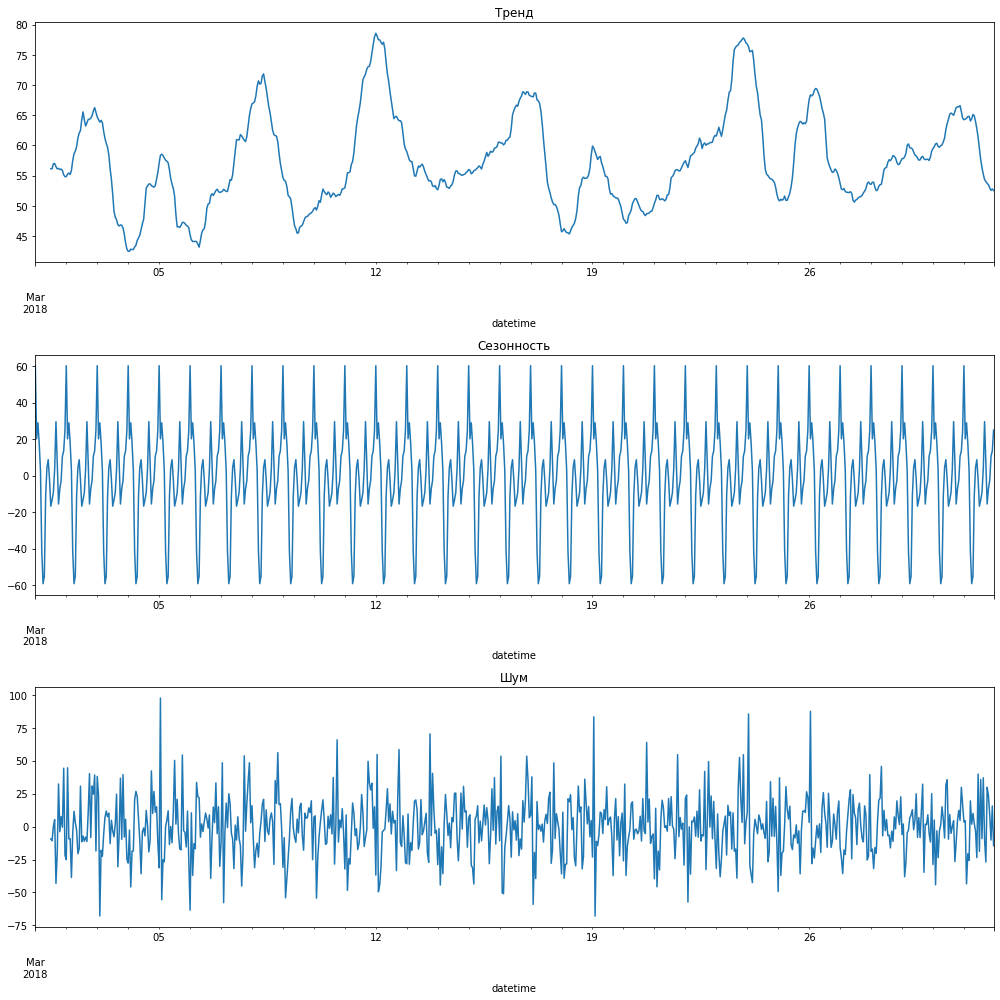

In [8]:
# один месяц
plot_decomposed('2018-03', '2018-03')

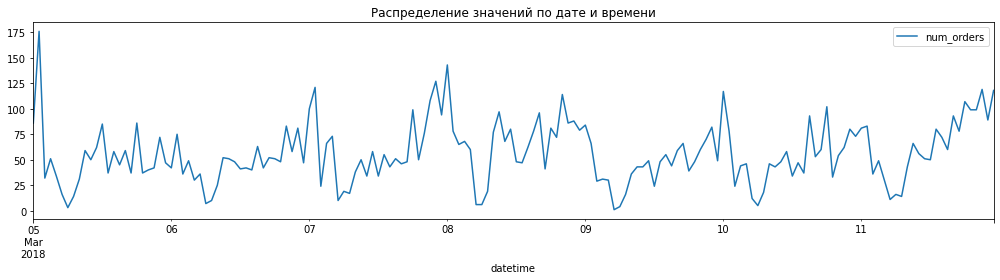

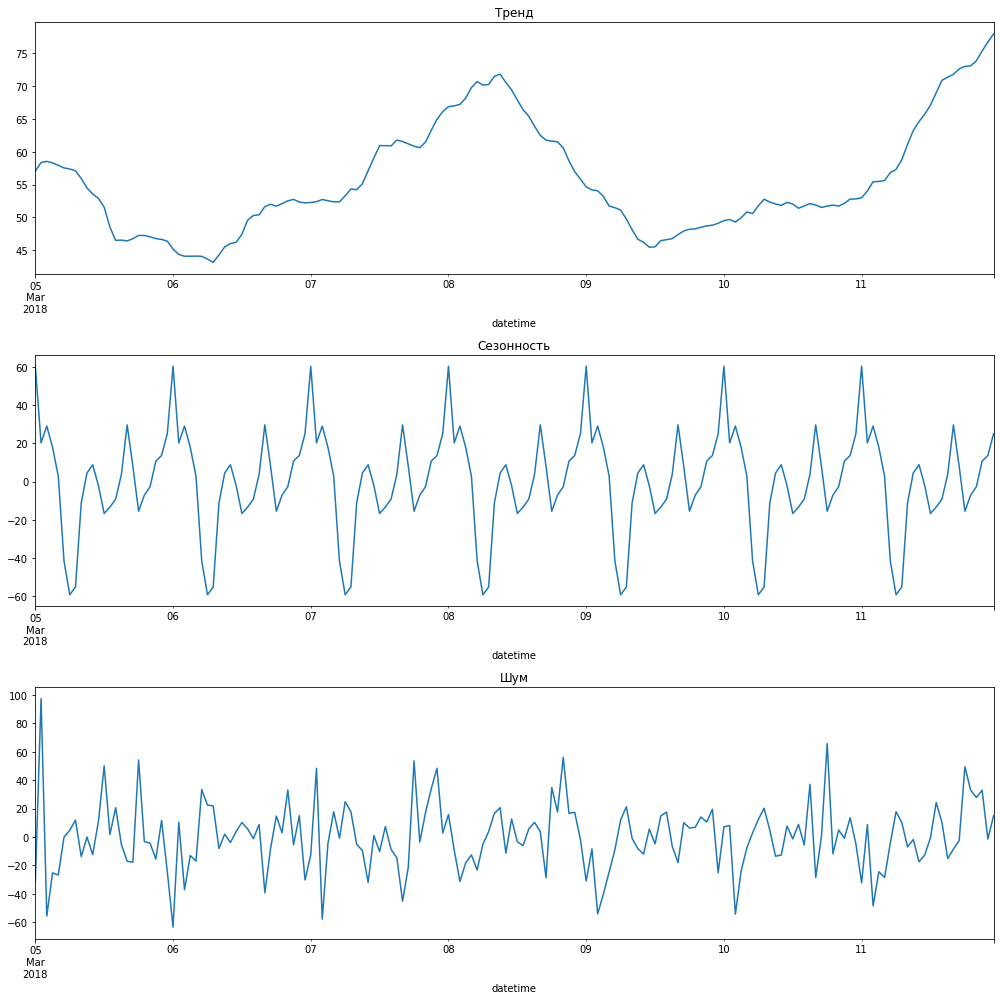

In [9]:
# одна неделя
plot_decomposed('2018-03-05', '2018-03-11')

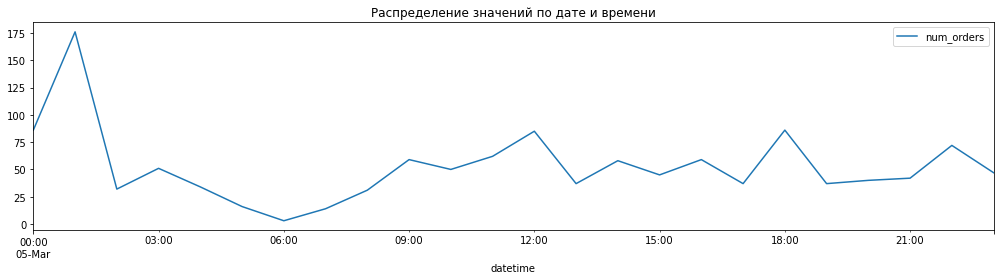

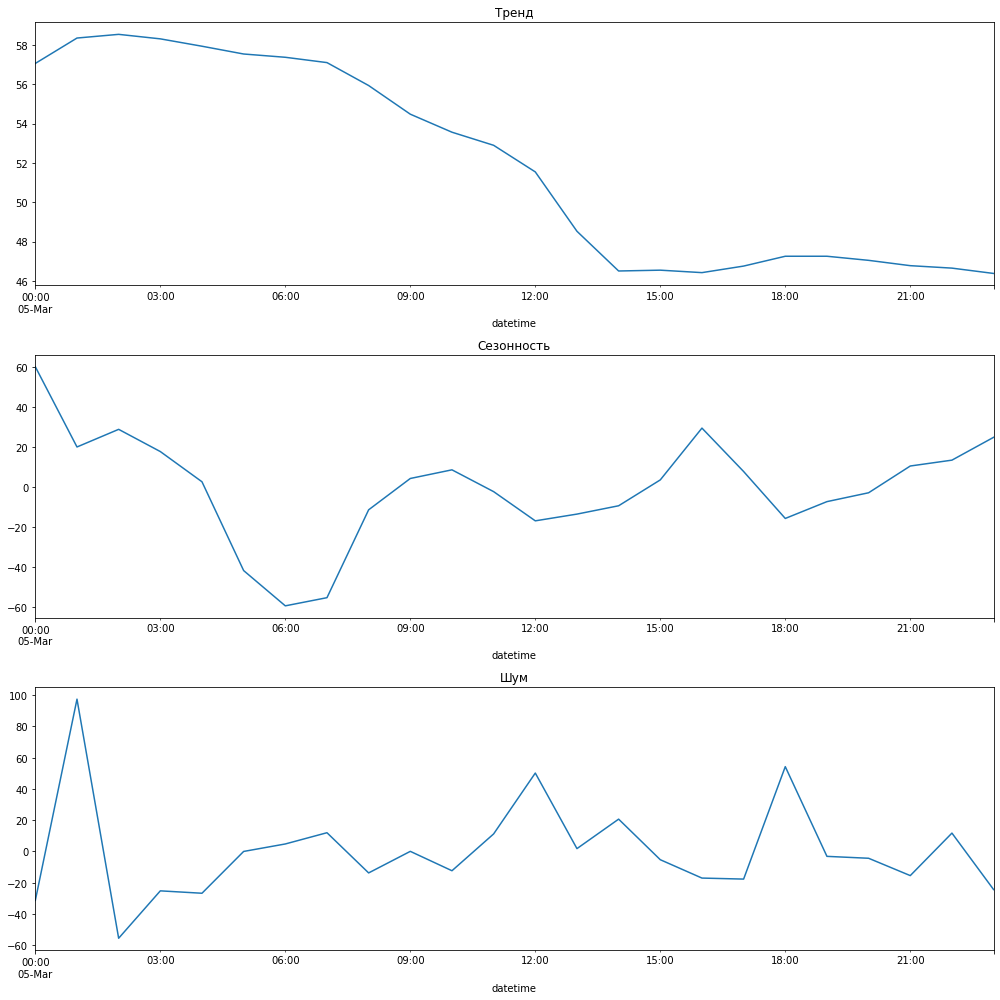

In [10]:
# один день
plot_decomposed('2018-03-05', '2018-03-05')

**Вывод**

На общем графике прослеживается тренд на увеличение количества заказов с каждым месяцем, данные августа сильно зашумлены. Отсутствует явный тренд на увеличение или уменьшение количества заказов в течение одного месяца, присутствует ярко выраженная сезонность по дням. На недельном графике видно, что спрос на такси растет утром понедельника, в четверг и воскресенье. Самые популярные временные интервалы: ночное время, обеденное время, утренние и вечерние часы пиковой нагрузки.

### Подготовка данных для моделей

Создадим признаки для горизонта прогнозирования, для этого напишем функцию:

In [8]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 6)

Разделим данные на тренировочную и тестовую части:

In [9]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Удалим отсутствующие значения из тренировочных данных, образовавшиеся в результате сдвига:

In [10]:
train = train.dropna()

Выделим признаки и целевой признак:

In [11]:
features_train=train.drop('num_orders',axis=1)
target_train=train['num_orders']
features_test=test.drop('num_orders',axis=1)
target_test=test['num_orders']

features_train.shape, features_test.shape

((3950, 27), (442, 27))

**Вывод**

В датасет добавлены дополнительные признаки. Данные разделены на тренировочную и тестовую подвыборки, выделены признаки и целевая переменная.

## Обучение и тестирование моделей

### Обучение моделей

Обучим модели случайного леса и два варианта градиентного бустинга, сравним значения метрики RMSE.

Функция, определяющая RMSE:

In [12]:
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

Функция для обучения модели и получения предсказаний:

In [16]:
def learn_predict(model, features_train, target_train, features_test):
    model.fit(features_train, target_train)
    predict = model.predict(features_test)
    return model, predict

Найдем лучшие параметры для случайного леса с помощью `GridSearch`:

In [14]:
%%time
tscv = TimeSeriesSplit()
model_rfr = RandomForestRegressor(random_state=1703)
parameters = {'n_estimators': [50, 100, 150], 'max_depth': [5, 7, 10]}
grid_rfr = GridSearchCV(model_rfr, parameters, cv=tscv, scoring='neg_root_mean_squared_error')
grid_rfr.fit(features_train, target_train)

scores = []
scores.append(grid_rfr.best_score_)
grid_rfr.best_params_, grid_rfr.best_score_

Wall time: 59.6 s


({'max_depth': 10, 'n_estimators': 150}, -25.223388913741097)

Проанализируем важность признаков для итоговой модели, создав для этого функцию:

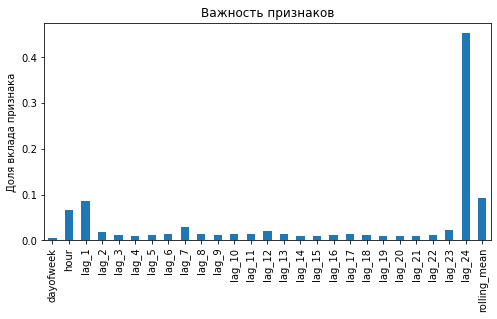

In [15]:
def features_importances(model):
    model_importances = pd.Series(model.feature_importances_, index=features_train.columns)
    model_importances.plot.bar(figsize=(8,4))
    plt.title("Важность признаков")
    plt.ylabel("Доля вклада признака");

features_importances(grid_rfr.best_estimator_)

Наиболее важные факторы по мнению `RandomForestRegressor`: разности временного ряда со сдвигом в 1 и 24 часа, час заказа, а также скользящее среднее. Остальные факторы практически не влияют на результаты предсказаний.

Найдем лучшие гиперпараметры для `CatBoostRegressor`:

In [20]:
%%time
model_cbr = CatBoostRegressor(loss_function='RMSE', verbose=False, random_state=1703)
parameters = {'depth' : [7, 10], 'learning_rate': [0.05, 0.1, 0.2]}
grid_cbr = GridSearchCV(model_cbr, parameters, scoring='neg_root_mean_squared_error', cv=tscv)
grid_cbr.fit(features_train, target_train)

scores.append(grid_cbr.best_score_)
grid_cbr.best_params_, grid_cbr.best_score_

Wall time: 10min 8s


({'depth': 7, 'learning_rate': 0.05}, -24.11357895576634)

Проанализируем важность признаков для модели:

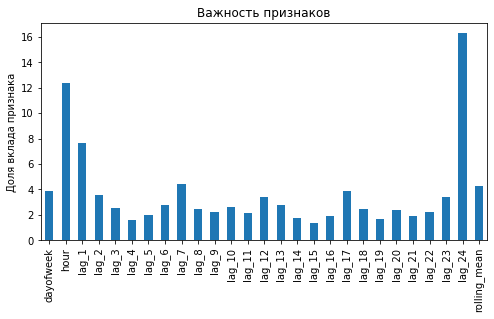

In [21]:
features_importances(grid_cbr.best_estimator_)

Наиболее важные факторы по мнению `CatBoostRegressor`: разность временного ряда со сдвигом в 24 часа, час заказа такси, а также скользящее среднее. Остальные факторы меньше влияют на результаты предсказаний.

Найдем лучшие параметры для `LightGBM`:

In [24]:
%%time
model_lgbm = LGBMRegressor(boosting_type='gbdt', seed=1703)
parameters = {'learning_rate': [0.05, 0.1], 'num_leaves': range(200, 801, 200), 'n_estimators': [200, 400, 600]}
grid_lgbm = GridSearchCV(model_lgbm, parameters, cv=tscv, scoring='neg_root_mean_squared_error')
grid_lgbm.fit(features_train, target_train)

scores.append(grid_lgbm.best_score_)
grid_lgbm.best_params_, grid_lgbm.best_score_

Wall time: 1min 34s


({'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 200},
 -25.02633504057917)

Проверим, какой признак внес наибольший вклад:

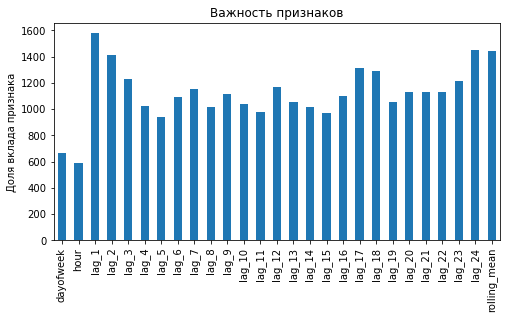

In [25]:
features_importances(grid_lgbm.best_estimator_)

Наиболее важные факторы по мнению `LightGBM`: разности временного ряда со сдвигом в 1, 2, 17, 18, 23, 24 часа, а также скользящее среднее. Наименьший вклад в предсказание вносит час заказа и день недели.

### Тестирование итоговой модели

Сформируем итоговую таблицу результатов:

In [26]:
result = pd.DataFrame(scores, columns=['RMSE'],
                        index=['RandomForestRegressor', 'CatBoostRegressor', 'LightGBM'])
result

,RMSE
RandomForestRegressor,-25.223389
CatBoostRegressor,-24.113579
LightGBM,-25.026335


Модели показали сравнимые результаты, лучшей стала модель, полученная с помощью LGBM. Сравним ее предсказания и истинные значения с помощью графика:

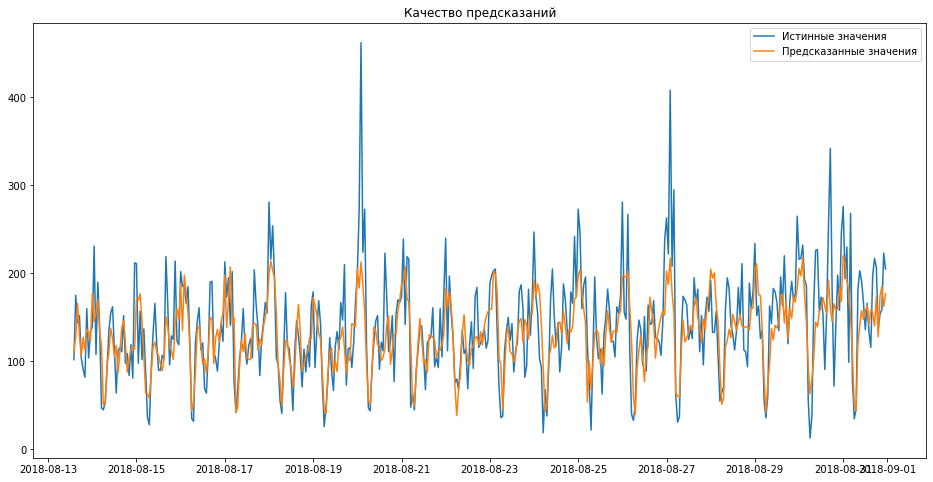

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(target_test, label='Истинные значения')
plt.plot(target_test.index, pred_lgbm, label='Предсказанные значения')
plt.title('Качество предсказаний')
plt.legend();

Оценим адекватность модели сравнив ее с моделью, предсказывающей с помощью предыдущего значения ряда:

In [30]:
pred_prev = target_test.shift(fill_value=target_train.iloc[-1])
print("Разница RMSE:", rmse(target_test, pred_prev) - rmse(target_test, pred_lgbm))

Разница RMSE: 17.623107116219053


Итоговая модель показала значительный прирост качества, а потому может считаться адекватной.

## Итоговый вывод

В ходе анализа данных обнаружен тренд и сезонность в значениях количества заказов: тренд на рост общего количества заказов, увеличение спроса на такси утром понедельника, в четверг и воскресенье. Самые популярные временные интервалы: ночное время, обеденное время, утренние и вечерние часы пиковой нагрузки.

Лучшей моделью для прогнозирования количества заказов такси на следующий час стала модель LGBM с показателем RMSE равным 41.2, что лучше показателя константной модели на 17,6. Предсказания модели пригодятся для привлечения большего количества водителей в период пиковой нагрузки.